In [239]:
import pandas as pd
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [240]:

scores = pd.read_parquet("fanta_scores.parquet")
scores = scores[(scores['Avg_Fanta_Score']!=0) | (scores['Season'] == '2023-2024')]
scores.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4840 entries, 0 to 5852
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            4840 non-null   int64  
 1   Season           4840 non-null   object 
 2   Player           4840 non-null   object 
 3   Squad            4840 non-null   object 
 4   F_Pos            4840 non-null   object 
 5   Match_Played     4840 non-null   int64  
 6   Avg_Fanta_Score  4840 non-null   float32
 7   Goal             4840 non-null   int64  
 8   Pen_Missed       4840 non-null   int64  
 9   Assist           4840 non-null   int64  
 10  YCards           4840 non-null   int64  
 11  RCards           4840 non-null   int64  
 12  Autogoal         4840 non-null   int8   
dtypes: float32(1), int64(7), int8(1), object(4)
memory usage: 477.4+ KB


In [241]:
prices = pd.read_parquet("fanta_prices.parquet")
prices['Season'] = '2023-2024'

prices.head()


,Squad_b,Player,Budget,PMAL,Season
0,ATA,ADOPO,0.002,0.002,2023-2024
1,ATA,BAKKER,0.020,0.014,2023-2024
2,ATA,CARNESECCHI,0.040,0.036,2023-2024
3,ATA,DE KETELAERE,0.002,0.006,2023-2024
4,ATA,DE ROON,0.010,0.002,2023-2024


In [242]:
stats = pd.read_parquet("fbref_stats_pl.parquet")
stats = stats[['Season','Player','Pos','Squad', 'Age','PrgC','PrgP','PrgR']]
stats.loc[stats['Squad'] == 'Hellas Verona', 'Squad'] = 'Verona'

stats.tail()

,Season,Player,Pos,Squad,Age,PrgC,PrgP,PrgR
5074,2023-2024,Joshua Zirkzee,FW,Bologna,22,1,2,7
5075,2023-2024,Zito,FW,Cagliari,21,0,0,6
5076,2023-2024,Nadir Zortea,DF,Atalanta,24,4,3,8
5077,2023-2024,Milan Đurić,"FW,MF",Verona,33,0,1,1
5078,2023-2024,Mateusz Łęgowski,MF,Salernitana,20,2,0,0


In [243]:
scores['Player'] = scores['Player'].str.upper().apply(lambda x: x.split(' ')[-2] if '.' in x.split(' ')[-1] else x.split(' ')[-1]).str.replace("'", "").apply(unidecode)
prices['Player'] = prices['Player'].str.upper().apply(lambda x: x.split(' ')[-2] if '.' in x.split(' ')[-1] else x.split(' ')[-1]).str.replace("'", "").apply(unidecode) 
stats['Player'] = stats['Player'].str.upper().apply(lambda x: x.split(' ')[-2] if '.' in x.split(' ')[-1] else x.split(' ')[-1]).str.replace("'", "").apply(unidecode)

scores['Squad_b'] = scores['Squad'].str.upper().str[:3]
# Join the dfFrames on the 'Last Name' column using an outer join


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4859 entries, 1800 to 4128
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                4859 non-null   int32  
 1   Squad                 4859 non-null   int32  
 2   F_Pos                 4859 non-null   object 
 3   Avg_Fanta_Score       4567 non-null   float64
 4   Budget                542 non-null    float64
 5   PMAL                  542 non-null    float64
 6   Pos                   4457 non-null   object 
 7   Age                   4457 non-null   float64
 8   Dep_Mates             4859 non-null   int64  
 9   New_Sign              4859 non-null   int32  
 10  N_season              4859 non-null   int64  
 11  Year                  4859 non-null   int32  
 12  Avg_Fanta_Score_lag1  3225 non-null   float64
 13  Match_Played_lag1     3241 non-null   float64
 14  Avg_Prg_lag1          3118 non-null   float64
 15  Dep_Mates_lag1        3

In [262]:
df = pd.merge(scores, prices, on=['Player', 'Squad_b', 'Season'], how='left')
df = pd.merge(df, stats, on=['Player', 'Season', 'Squad'], how='left')
df['Avg_Fanta_Score'] = df['Avg_Fanta_Score'] + (
                        df['Goal'] * 3 + df['Assist'] - df['Autogoal'] * 2 - 
                        df['YCards'] * 0.5 - df['RCards'] - df['Pen_Missed'] * 3
                    ) / df['Match_Played']

features_to_scale =['PrgC','PrgP','PrgR']
df [features_to_scale] = df[features_to_scale].div(df['Match_Played'], axis = 0)
df['Dep_Mates'] = df.groupby(['F_Pos', 'Season', 'Squad'])['Player'].transform('count')

df.sort_values(by=['Player', 'Season'], inplace=True)


df['New_Sign'] = (df['Squad'] != df.groupby('Player')['Squad'].shift(1)) | (df.groupby('Player')['Squad'].shift(1).isnull())
df['New_Sign'] = df['New_Sign'].astype(int)

df['N_season'] = df.groupby('Player')['Season'].transform('count')
df['Rank'] = df.groupby(['F_Pos', 'Squad', 'Season'])['Avg_Fanta_Score'].rank(ascending=False)


relegated_promoted_teams = ['Spezia','Venezia', 'Palermo', 'Carpi', 'Parma','Crotone', 'Cremonese', 'Benevento','Pescara','Frosinone', 'Chievo','Brescia','SPAL','Sampodoria']
df.loc[df['Squad'].isin(relegated_promoted_teams), 'Squad'] = 'Relegated'
df['Year'] = df['Season'].str[-4:].astype(int)

encoder = LabelEncoder()
df['Squad'] = encoder.fit_transform(df['Squad'])
#df['Player'] = encoder.fit_transform(df['Player'])
df['Avg_Prg'] = (df['PrgC'] + df['PrgP'] + df['PrgR'] )/3

df = df.drop(columns=['Goal','Assist','Autogoal','YCards','RCards','Squad_b','Season', 'PrgC', 'PrgP', 'PrgR'])

lag_columns = ['Avg_Fanta_Score', 'Match_Played', 'Avg_Prg', 'Dep_Mates', 'Rank']
num_lags = 2

df = df.sort_values(by=['Player', 'Year', 'Squad'])

# Shift the required columns
for lag_period in range(1, num_lags + 1):
    shifted = df.groupby(["Player"])[lag_columns].shift(lag_period)
    df = pd.concat([df, shifted.rename(columns=lambda col: f"{col}_lag{lag_period}")], axis=1)

df.drop(columns=['Match_Played', 'Avg_Prg', 'index', 'Pen_Missed' ,'Rank'], inplace=True)
df = df[
    (df['Year'] > (min(df['Year']) + num_lags - 1)) &
    (pd.isna(df['Avg_Fanta_Score_lag1']) == False) &
    (pd.isna(df['Avg_Fanta_Score_lag2']) == False)|(df['Year']==2024)]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2439 entries, 4638 to 2283
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                2439 non-null   object 
 1   Squad                 2439 non-null   int32  
 2   F_Pos                 2439 non-null   object 
 3   Avg_Fanta_Score       2147 non-null   float64
 4   Budget                542 non-null    float64
 5   PMAL                  542 non-null    float64
 6   Pos                   2135 non-null   object 
 7   Age                   2135 non-null   float64
 8   Dep_Mates             2439 non-null   int64  
 9   New_Sign              2439 non-null   int32  
 10  N_season              2439 non-null   int64  
 11  Year                  2439 non-null   int32  
 12  Avg_Fanta_Score_lag1  2291 non-null   float64
 13  Match_Played_lag1     2307 non-null   float64
 14  Avg_Prg_lag1          2229 non-null   float64
 15  Dep_Mates_lag1        2

In [263]:
bk24 = df[(df['F_Pos']=='D')&(df['Year']==2024)].drop(columns = ['Pos',  'F_Pos', 'Budget', 'PMAL'])
mid24 = df[(df['F_Pos']=='C')&(df['Year']==2024)].drop(columns = ['Pos', 'F_Pos', 'Budget', 'PMAL'])
mid24 = df[(df['F_Pos']=='A')&(df['Year']==2024)].drop(columns = ['Pos', 'F_Pos', 'Budget', 'PMAL'])

bk = df[(df['F_Pos']=='D')&(df['Year']<2024)].drop(columns = ['Pos',  'F_Pos','Budget', 'PMAL'])
mid = df[(df['F_Pos']=='C')&(df['Year']<2024)].drop(columns = ['Pos', 'F_Pos','Budget', 'PMAL'])
att = df[(df['F_Pos']=='A')&(df['Year']<2024)].drop(columns = ['Pos', 'F_Pos','Budget', 'PMAL'])

budget = df[(df['Year'] == 2024)][['Player','Squad','Year','Budget', 'PMAL']]


mid.head()

,Player,Squad,Avg_Fanta_Score,Age,Dep_Mates,New_Sign,N_season,Year,Avg_Fanta_Score_lag1,Match_Played_lag1,Avg_Prg_lag1,Dep_Mates_lag1,Rank_lag1,Avg_Fanta_Score_lag2,Match_Played_lag2,Avg_Prg_lag2,Dep_Mates_lag2,Rank_lag2
2068,A,3,6.000000,NaN,7,1,5,2019,5.670909,33.0,NaN,10.0,3.0,5.250000,2.0,NaN,13.0,13.0
1486,BABACAR,17,6.606428,24.0,6,1,5,2018,7.570000,20.0,0.000000,5.0,2.0,7.141429,14.0,0.000000,6.0,1.0
2003,BABACAR,17,6.754615,25.0,6,0,5,2019,6.606428,28.0,0.904762,6.0,2.0,7.570000,20.0,0.000000,5.0,2.0
2579,BABACAR,9,5.711667,26.0,5,1,5,2020,6.754615,26.0,1.743590,6.0,2.0,6.606428,28.0,0.904762,6.0,2.0
2525,BARROW,1,7.280000,20.0,7,1,7,2020,5.996471,17.0,2.686275,5.0,4.0,7.551111,9.0,2.888889,5.0,1.0


<Axes: >

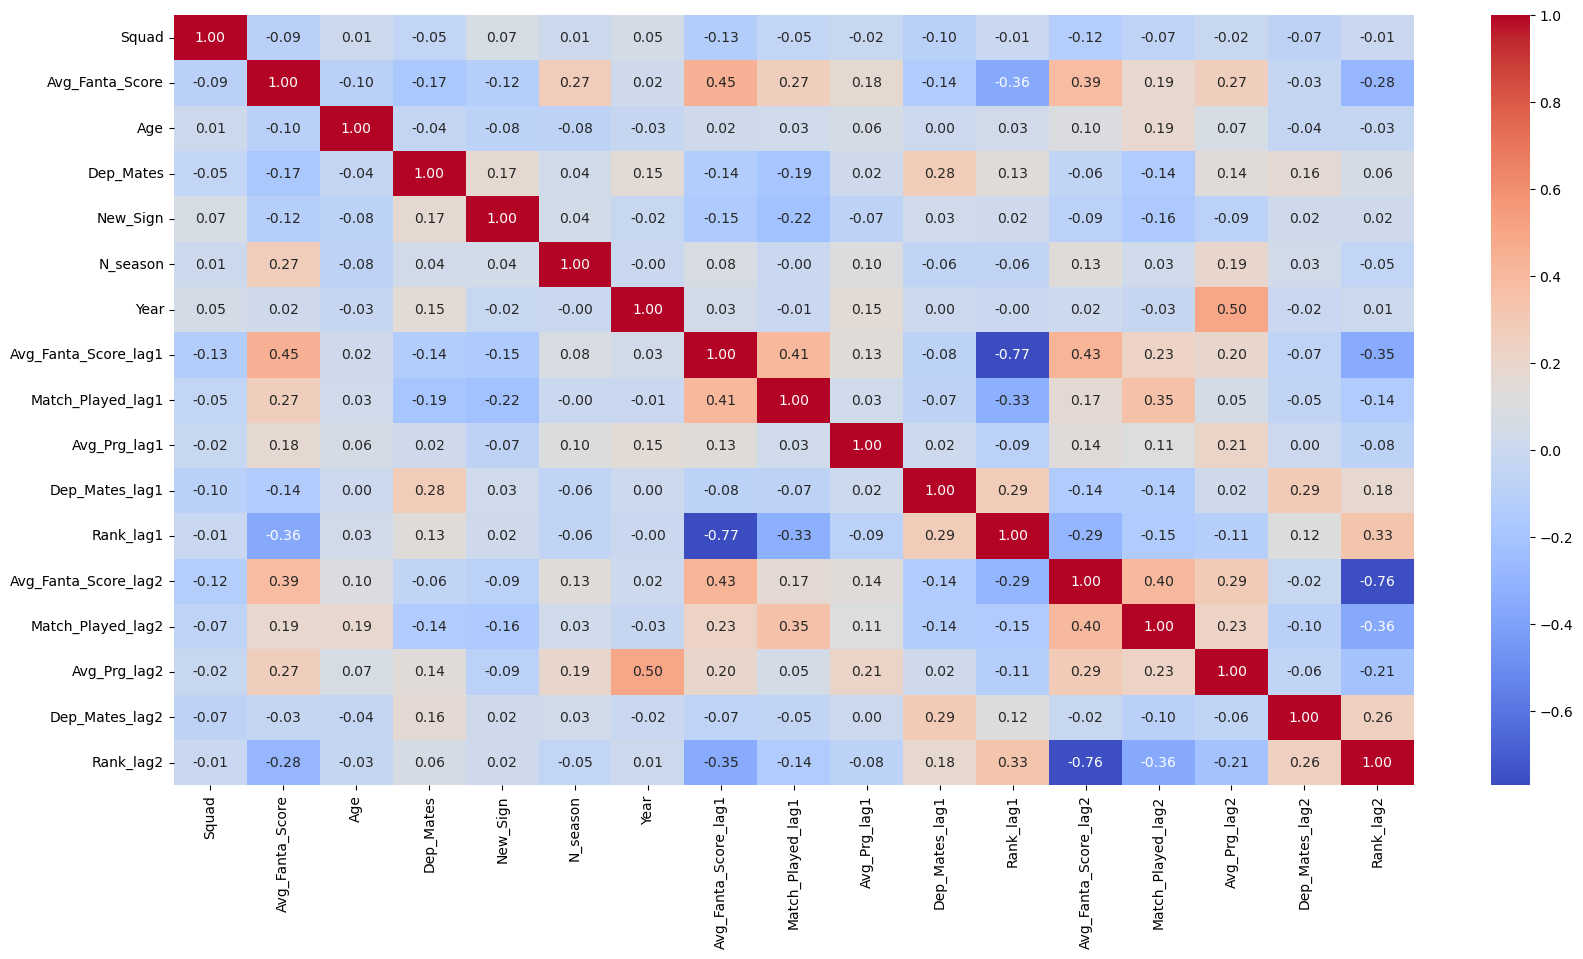

In [283]:
plt.figure(figsize=(20, 10))
sns.heatmap(mid.select_dtypes(include=['number', 'boolean']).corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [284]:

mid_test = mid[mid['Year']==2023]
mid_train = mid[mid['Year']<2023]

Xt = mid_test.drop([ 'Avg_Fanta_Score', 'Player'], axis=1)
X = mid_train.drop(['Avg_Fanta_Score', 'Player'], axis=1)

yt = mid_test['Avg_Fanta_Score']
y = mid_train['Avg_Fanta_Score']

Xt24 = mid24.drop(['Avg_Fanta_Score', 'Player'], axis=1)

In [285]:
# Define categorical feature indices
categorical_feature_indices = [0,1, 5]

# Create a LightGBM Dataset with categorical features
lgb_data = lgb.Dataset(X, label=y, categorical_feature=categorical_feature_indices, free_raw_data=False)

# Set up LightGBM parameters for regression and train the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'l2',
    'metric': 'l2',  
    'verbosity': -1,
    'force_col_wise': True
}

# Step 1: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [32, 64, 128],
    'max_depth': [4, 6, 8],
    'min_split_gain': [0, 0.05, 0.1],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0]
    
    # Add more hyperparameters to tune
}

grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(**params),
                        param_grid=param_grid,
                        scoring='neg_mean_squared_log_error',
                        cv=3,
                        verbose=1)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 2: Evaluate the Refined Model
y_pred = best_model.predict(Xt)
rmse = mean_squared_error(yt, y_pred, squared=False)

print("Root Mean Squared Error:", rmse)
print("Best Hyperparameters:", best_params)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Root Mean Squared Error: 0.4120048842911211
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_split_gain': 0.1, 'num_leaves': 32, 'reg_alpha': 0.5, 'reg_lambda': 0.1}


In [286]:
# Combine the new data with the original training data
combined_X_train = pd.concat([X, Xt], axis=0, ignore_index=True)
combined_y_train = pd.concat([y, yt], axis=0,ignore_index=True)

# Retrain the best model on the combined dataset
updated_model = best_model.fit(combined_X_train, combined_y_train)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

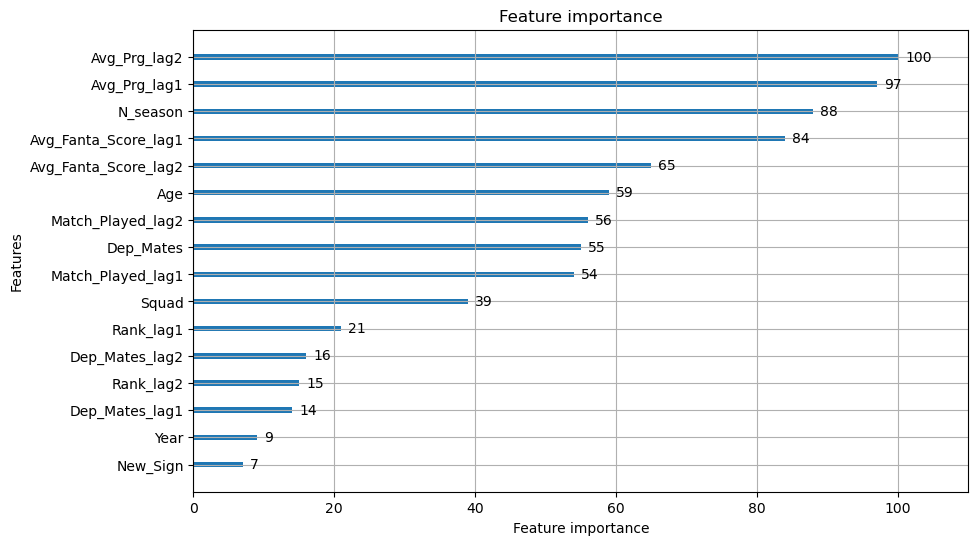

In [287]:
lgb.plot_importance(updated_model, figsize=(10, 6))


In [289]:
y_pred24 = updated_model.predict(Xt24)

predictions_df = pd.DataFrame({
    'Prediction': y_pred24,
    'Player': mid24.loc[Xt24.index, 'Player'],
    'Squad': mid24.loc[Xt24.index, 'Squad']
})

predictions_df = pd.merge(predictions_df, budget,on=['Squad', 'Player'],how='inner')

# Print the predictions DataFrame
print(predictions_df)
predictions_df.to_csv('mid_predictions.csv')

     Prediction     Player  Squad  Year  Budget   PMAL
0      5.733817                12  2024     NaN    NaN
1      5.811264       ADLI     10  2024   0.002  0.002
2      6.095050      ADOPO      0  2024   0.002  0.002
3      5.846857  AEBISCHER      1  2024   0.016  0.003
4      5.817518      AKPRO      8  2024     NaN    NaN
..          ...        ...    ...   ...     ...    ...
276    6.643169   ZACCAGNI      8  2024   0.120  0.120
277    6.025995   ZALEWSKI     14  2024   0.002  0.002
278    5.987684    ZARRAGA     19  2024   0.002  0.002
279    5.886129     ZERBIN     12  2024   0.002  0.002
280    6.651384  ZIELINSKI     12  2024   0.050  0.044

[281 rows x 6 columns]
